# Controllers

This notebook implements and compares three trajectory tracking controllers based on the error dynamics formulation:

1. **LQR + Feedforward** — Closed-form optimal linear feedback
2. **QP-MPC (OSQP)** — Convex MPC with constraint handling, suitable for embedded
3. **Nonlinear MPC** — Full nonlinear dynamics, maximum accuracy

All controllers use the decomposition:

$$\mathbf{u} = \mathbf{u}_{ref} + \delta\mathbf{u}$$

where $\mathbf{u}_{ref}$ is the feedforward from the reference trajectory and $\delta\mathbf{u}$ is the feedback correction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are

from utils import angle_wrap, state_error, generate_smooth_reference_trajectory
from mpc_controller import QPMPC, NonlinearMPC, compute_jacobians_at_state

In [2]:
# Robot parameters
L = 0.14        # wheelbase [m]
tau = 0.2       # motor time constant [s]
v_cruise = 0.25 # cruise speed [m/s]
u_max = 0.5     # max wheel command [m/s]

# State dimensions
n_x, n_u = 5, 2

# Simulation parameters
T_final = 60.0
dt = 0.05       # 20 Hz
t = np.arange(0, T_final, dt)
N = len(t)

# Noise covariances (for realistic simulation)
Q_noise = np.diag([1e-5, 1e-5, 1e-6, 1e-4, 1e-4])  # process
Q_noise_chol = np.linalg.cholesky(Q_noise)

# Random seed for reproducibility
rng = np.random.default_rng(42)

print(f"Robot: L={L*100:.0f}cm, τ={tau}s, v_cruise={v_cruise}m/s")
print(f"Simulation: {T_final}s at {1/dt:.0f}Hz ({N} steps)")

Robot: L=14cm, τ=0.2s, v_cruise=0.25m/s
Simulation: 60.0s at 20Hz (1200 steps)


In [3]:
def nonlinear_dynamics(x, u, dt_step, L, tau):
    """
    Propagate state using nonlinear tank drive dynamics.
    
    State: [x, y, theta, v_l, v_r]
    Input: [u_l, u_r] (wheel velocity commands)
    
    Kinematics:
        ẋ = (v_l + v_r)/2 * cos(θ)
        ẏ = (v_l + v_r)/2 * sin(θ)
        θ̇ = (v_r - v_l) / L
    
    Motor dynamics:
        v̇_l = (u_l - v_l) / τ
        v̇_r = (u_r - v_r) / τ
    """
    x_pos, y_pos, theta, v_l, v_r = x
    u_l, u_r = u
    
    v_avg = (v_l + v_r) / 2.0
    
    x_dot = v_avg * np.cos(theta)
    y_dot = v_avg * np.sin(theta)
    theta_dot = (v_r - v_l) / L
    v_l_dot = (-v_l + u_l) / tau
    v_r_dot = (-v_r + u_r) / tau
    
    return np.array([
        x_pos + x_dot * dt_step,
        y_pos + y_dot * dt_step,
        theta + theta_dot * dt_step,
        v_l + v_l_dot * dt_step,
        v_r + v_r_dot * dt_step
    ])

## Reference Trajectory

Generate a waypoint trajectory with turns. See [Reference Trajectories](Reference%20Trajectories.ipynb) for details.

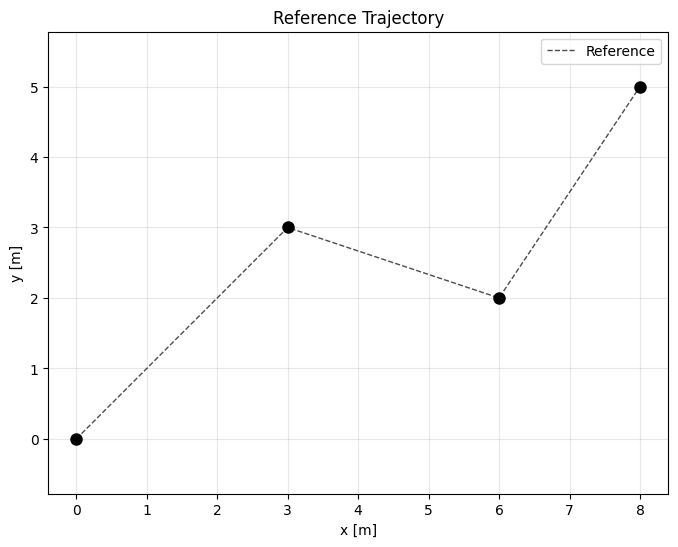

In [4]:
waypoints = np.array([
    [0.0, 0.0],
    [3.0, 3.0],
    [6.0, 2.0],
    [8.0, 5.0],
])

x_ref, u_ref = generate_smooth_reference_trajectory(waypoints, t, v_cruise, L, tau, turn_time=1.0)

# Quick plot
plt.figure(figsize=(8, 6))
plt.plot(x_ref[0, :], x_ref[1, :], 'k--', linewidth=1, alpha=0.7, label='Reference')
plt.plot(waypoints[:, 0], waypoints[:, 1], 'ko', markersize=8)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Reference Trajectory')
plt.show()

## Controller 1: LQR + Feedforward

The LQR controller computes an optimal linear feedback gain $K$ that minimizes:

$$J = \sum_{k=0}^{\infty} \left( \mathbf{e}_k^T Q \mathbf{e}_k + \delta\mathbf{u}_k^T R \delta\mathbf{u}_k \right)$$

The control law is:

$$\mathbf{u} = \mathbf{u}_{ref} - K \mathbf{e}$$

where $\mathbf{e} = \mathbf{x} - \mathbf{x}_{ref}$ (with angle wrapping on $\theta$).

### Implementation

The gain $K$ is computed by solving the discrete-time algebraic Riccati equation (DARE).

In [5]:
# LQR cost weights
Q_lqr = np.diag([20.0, 20.0, 5.0, 0.1, 0.1])  # [x, y, θ, v_l, v_r]
R_lqr = np.diag([1.0, 1.0])                    # [u_l, u_r]

# Linearize at nominal forward motion (θ=0, v=v_cruise)
# This is a design choice - the gain won't be optimal everywhere
x_nom = np.array([0, 0, 0, v_cruise, v_cruise])
A_c, B_c = compute_jacobians_at_state(x_nom, L, tau)

# Discretize
A_d = np.eye(n_x) + dt * A_c
B_d = dt * B_c

# Solve DARE for LQR gain
P_lqr = solve_discrete_are(A_d, B_d, Q_lqr, R_lqr)
K_lqr = np.linalg.solve(R_lqr + B_d.T @ P_lqr @ B_d, B_d.T @ P_lqr @ A_d)

print("LQR gain K:")
print(K_lqr)
print(f"\nGain norm: {np.linalg.norm(K_lqr):.2f}")

LQR gain K:
[[ 2.94961927 -2.33429605 -1.29104298  1.40202752 -0.8646227 ]
 [ 2.94961927  2.33429605  1.29104298 -0.8646227   1.40202752]]

Gain norm: 6.09


In [6]:
def lqr_ff_control(x, x_ref, u_ref, K, u_max):
    """
    LQR + Feedforward control.
    
    u = u_ref - K @ (x - x_ref)
    """
    e = state_error(x, x_ref)
    u = u_ref - K @ e
    return np.clip(u, -u_max, u_max)

In [7]:
# Simulate LQR+FF
x_lqr = np.zeros((n_x, N))
u_lqr = np.zeros((n_u, N))
x_lqr[:, 0] = x_ref[:, 0]  # Start on reference

rng_lqr = np.random.default_rng(42)
final_waypoint = waypoints[-1]
goal_tol = 0.1  # 10cm tolerance

final_k_lqr = N - 1
for k in range(N - 1):
    # Control
    u_lqr[:, k] = lqr_ff_control(x_lqr[:, k], x_ref[:, k], u_ref[:, k], K_lqr, u_max)
    
    # Propagate with noise
    w = Q_noise_chol @ rng_lqr.standard_normal(n_x)
    x_lqr[:, k+1] = nonlinear_dynamics(x_lqr[:, k], u_lqr[:, k], dt, L, tau) + w
    
    # Early termination when goal reached
    dist_to_goal = np.sqrt((x_lqr[0, k+1] - final_waypoint[0])**2 + 
                           (x_lqr[1, k+1] - final_waypoint[1])**2)
    if dist_to_goal < goal_tol and k > 50:
        final_k_lqr = k + 1
        break

# Trim to actual length
x_lqr = x_lqr[:, :final_k_lqr + 1]
u_lqr = u_lqr[:, :final_k_lqr + 1]
t_lqr = t[:final_k_lqr + 1]
x_ref_lqr = x_ref[:, :final_k_lqr + 1]

# Compute tracking error
err_lqr = np.sqrt((x_lqr[0, :] - x_ref_lqr[0, :])**2 + (x_lqr[1, :] - x_ref_lqr[1, :])**2)
rms_lqr = np.sqrt(np.mean(err_lqr**2))

print(f"LQR+FF: {final_k_lqr + 1} steps ({(final_k_lqr + 1)*dt:.1f}s)")
print(f"LQR+FF tracking RMS error: {rms_lqr*100:.2f} cm")

LQR+FF: 917 steps (45.9s)
LQR+FF tracking RMS error: 2.27 cm


## Controller 2: QP-MPC (OSQP)

Model Predictive Control solves an optimization problem at each timestep:

$$\min_{\delta\mathbf{u}_{0:N-1}} \sum_{k=0}^{N} \mathbf{e}_k^T Q \mathbf{e}_k + \sum_{k=0}^{N-1} \delta\mathbf{u}_k^T R \delta\mathbf{u}_k + \sum_{k=0}^{N-1} \Delta\mathbf{u}_k^T R_{rate} \Delta\mathbf{u}_k$$

subject to:
- Error dynamics: $\mathbf{e}_{k+1} = A \mathbf{e}_k + B \delta\mathbf{u}_k$
- Input bounds: $|\mathbf{u}_{ref} + \delta\mathbf{u}| \leq u_{max}$

### Rate Penalty

The $R_{rate}$ term penalizes $\Delta\mathbf{u} = \mathbf{u}_k - \mathbf{u}_{k-1}$. This is crucial for systems with motor dynamics — rapid control changes cannot be tracked by slow actuators.

In [8]:
# QP-MPC parameters
Q_mpc = np.diag([10.0, 10.0, 5.0, 0.1, 0.1])
R_mpc = np.diag([0.1, 0.1])
R_rate = np.diag([2.0, 2.0])  # Rate penalty for smooth control
N_horizon = 15  # 0.75s at 20Hz

mpc_qp = QPMPC(L, tau, dt, Q_mpc, R_mpc, R_rate, N_horizon, u_max, exp_weight=1.0)

print(f"QP-MPC initialized:")
print(f"  Horizon: {N_horizon} steps ({N_horizon*dt:.2f}s)")
print(f"  Rate penalty: {R_rate[0,0]:.1f}")

QP-MPC initialized:
  Horizon: 15 steps (0.75s)
  Rate penalty: 2.0


In [9]:
# Simulate QP-MPC
x_qpmpc = np.zeros((n_x, N))
u_qpmpc = np.zeros((n_u, N))
x_qpmpc[:, 0] = x_ref[:, 0]

rng_qpmpc = np.random.default_rng(42)
mpc_qp.reset()  # Clear warm start

solve_times = []

import time
print("Running QP-MPC simulation...")

final_k_qpmpc = N - 1
for k in range(N - 1):
    # Get reference horizon
    k_end = min(k + N_horizon + 1, N)
    x_ref_h = x_ref[:, k:k_end]
    u_ref_h = u_ref[:, k:k_end]
    
    # Pad if needed
    if x_ref_h.shape[1] < N_horizon + 1:
        pad = N_horizon + 1 - x_ref_h.shape[1]
        x_ref_h = np.hstack([x_ref_h, np.tile(x_ref[:, -1:], (1, pad))])
        u_ref_h = np.hstack([u_ref_h, np.tile(u_ref[:, -1:], (1, pad))])
    
    # Control
    t0 = time.perf_counter()
    u_qpmpc[:, k] = mpc_qp.compute_control(x_qpmpc[:, k], x_ref_h, u_ref_h)
    solve_times.append(time.perf_counter() - t0)
    
    # Propagate
    w = Q_noise_chol @ rng_qpmpc.standard_normal(n_x)
    x_qpmpc[:, k+1] = nonlinear_dynamics(x_qpmpc[:, k], u_qpmpc[:, k], dt, L, tau) + w
    
    # Early termination when goal reached
    dist_to_goal = np.sqrt((x_qpmpc[0, k+1] - final_waypoint[0])**2 + 
                           (x_qpmpc[1, k+1] - final_waypoint[1])**2)
    if dist_to_goal < goal_tol and k > 50:
        final_k_qpmpc = k + 1
        break

# Trim to actual length
x_qpmpc = x_qpmpc[:, :final_k_qpmpc + 1]
u_qpmpc = u_qpmpc[:, :final_k_qpmpc + 1]
t_qpmpc = t[:final_k_qpmpc + 1]
x_ref_qpmpc = x_ref[:, :final_k_qpmpc + 1]

err_qpmpc = np.sqrt((x_qpmpc[0, :] - x_ref_qpmpc[0, :])**2 + (x_qpmpc[1, :] - x_ref_qpmpc[1, :])**2)
rms_qpmpc = np.sqrt(np.mean(err_qpmpc**2))

print(f"\nQP-MPC: {final_k_qpmpc + 1} steps ({(final_k_qpmpc + 1)*dt:.1f}s)")
print(f"QP-MPC tracking RMS error: {rms_qpmpc*100:.2f} cm")
print(f"Solve time: {np.mean(solve_times)*1000:.2f} ms avg, {np.max(solve_times)*1000:.2f} ms max")

Running QP-MPC simulation...


/opt/venv/lib/python3.13/site-packages/osqp/interface.py:229: UserWarning: Converting sparse A to a CSC matrix. This may take a while...
  warnings.warn('Converting sparse A to a CSC matrix. This may take a while...')



QP-MPC: 919 steps (46.0s)
QP-MPC tracking RMS error: 4.05 cm
Solve time: 2.79 ms avg, 6.89 ms max


## Controller 3: Nonlinear MPC

Nonlinear MPC uses the full nonlinear dynamics for prediction:

$$\mathbf{x}_{k+1} = f(\mathbf{x}_k, \mathbf{u}_k)$$

This makes the optimization **non-convex** — it cannot be formulated as a QP. The trade-offs vs QP-MPC:

| Aspect | QP-MPC | NL-MPC |
|--------|--------|--------|
| Dynamics | Linearized | Full nonlinear |
| Problem | Convex QP | Non-convex NLP |
| Solve time | ~2 ms | ~20 ms |
| Convergence | Guaranteed | May find local min |
| Embedded | Yes (OSQP) | Difficult |

In [10]:
# NL-MPC parameters
Q_nl = np.diag([10.0, 10.0, 5.0, 0.1, 0.1])
R_nl = np.diag([0.1, 0.1])
N_horizon_nl = 10
N_control_nl = 5  # Control horizon (reduces optimization variables)

# Create dynamics function for NL-MPC
# The MPC accepts a generic f(x, u, dt) -> x_next interface
def dynamics_for_mpc(x, u, dt_step):
    return nonlinear_dynamics(x, u, dt_step, L, tau)

mpc_nl = NonlinearMPC(dynamics_for_mpc, dt, Q_nl, R_nl, N_horizon_nl, N_control_nl, u_max)

print(f"NL-MPC initialized:")
print(f"  Prediction horizon: {N_horizon_nl} steps ({N_horizon_nl*dt:.2f}s)")
print(f"  Control horizon: {N_control_nl} steps")

NL-MPC initialized:
  Prediction horizon: 10 steps (0.50s)
  Control horizon: 5 steps


In [11]:
# Simulate NL-MPC
x_nlmpc = np.zeros((n_x, N))
u_nlmpc = np.zeros((n_u, N))
x_nlmpc[:, 0] = x_ref[:, 0]

rng_nlmpc = np.random.default_rng(42)
mpc_nl.reset()

solve_times_nl = []

print("Running NL-MPC simulation (slower)...")

final_k_nlmpc = N - 1
for k in range(N - 1):
    # Get reference horizon
    k_end = min(k + N_horizon_nl + 1, N)
    x_ref_h = x_ref[:, k:k_end]
    u_ref_h = u_ref[:, k:k_end]
    
    # Pad if needed
    if x_ref_h.shape[1] < N_horizon_nl + 1:
        pad = N_horizon_nl + 1 - x_ref_h.shape[1]
        x_ref_h = np.hstack([x_ref_h, np.tile(x_ref[:, -1:], (1, pad))])
        u_ref_h = np.hstack([u_ref_h, np.tile(u_ref[:, -1:], (1, pad))])
    
    # Control
    t0 = time.perf_counter()
    u_nlmpc[:, k] = mpc_nl.compute_control(x_nlmpc[:, k], x_ref_h, u_ref_h)
    solve_times_nl.append(time.perf_counter() - t0)
    
    # Propagate
    w = Q_noise_chol @ rng_nlmpc.standard_normal(n_x)
    x_nlmpc[:, k+1] = nonlinear_dynamics(x_nlmpc[:, k], u_nlmpc[:, k], dt, L, tau) + w
    
    # Early termination when goal reached
    dist_to_goal = np.sqrt((x_nlmpc[0, k+1] - final_waypoint[0])**2 + 
                           (x_nlmpc[1, k+1] - final_waypoint[1])**2)
    if dist_to_goal < goal_tol and k > 50:
        final_k_nlmpc = k + 1
        break

# Trim to actual length
x_nlmpc = x_nlmpc[:, :final_k_nlmpc + 1]
u_nlmpc = u_nlmpc[:, :final_k_nlmpc + 1]
t_nlmpc = t[:final_k_nlmpc + 1]
x_ref_nlmpc = x_ref[:, :final_k_nlmpc + 1]

err_nlmpc = np.sqrt((x_nlmpc[0, :] - x_ref_nlmpc[0, :])**2 + (x_nlmpc[1, :] - x_ref_nlmpc[1, :])**2)
rms_nlmpc = np.sqrt(np.mean(err_nlmpc**2))

print(f"\nNL-MPC: {final_k_nlmpc + 1} steps ({(final_k_nlmpc + 1)*dt:.1f}s)")
print(f"NL-MPC tracking RMS error: {rms_nlmpc*100:.2f} cm")
print(f"Solve time: {np.mean(solve_times_nl)*1000:.2f} ms avg, {np.max(solve_times_nl)*1000:.2f} ms max")

Running NL-MPC simulation (slower)...



NL-MPC: 914 steps (45.7s)
NL-MPC tracking RMS error: 2.63 cm
Solve time: 8.90 ms avg, 16.18 ms max


## Comparison

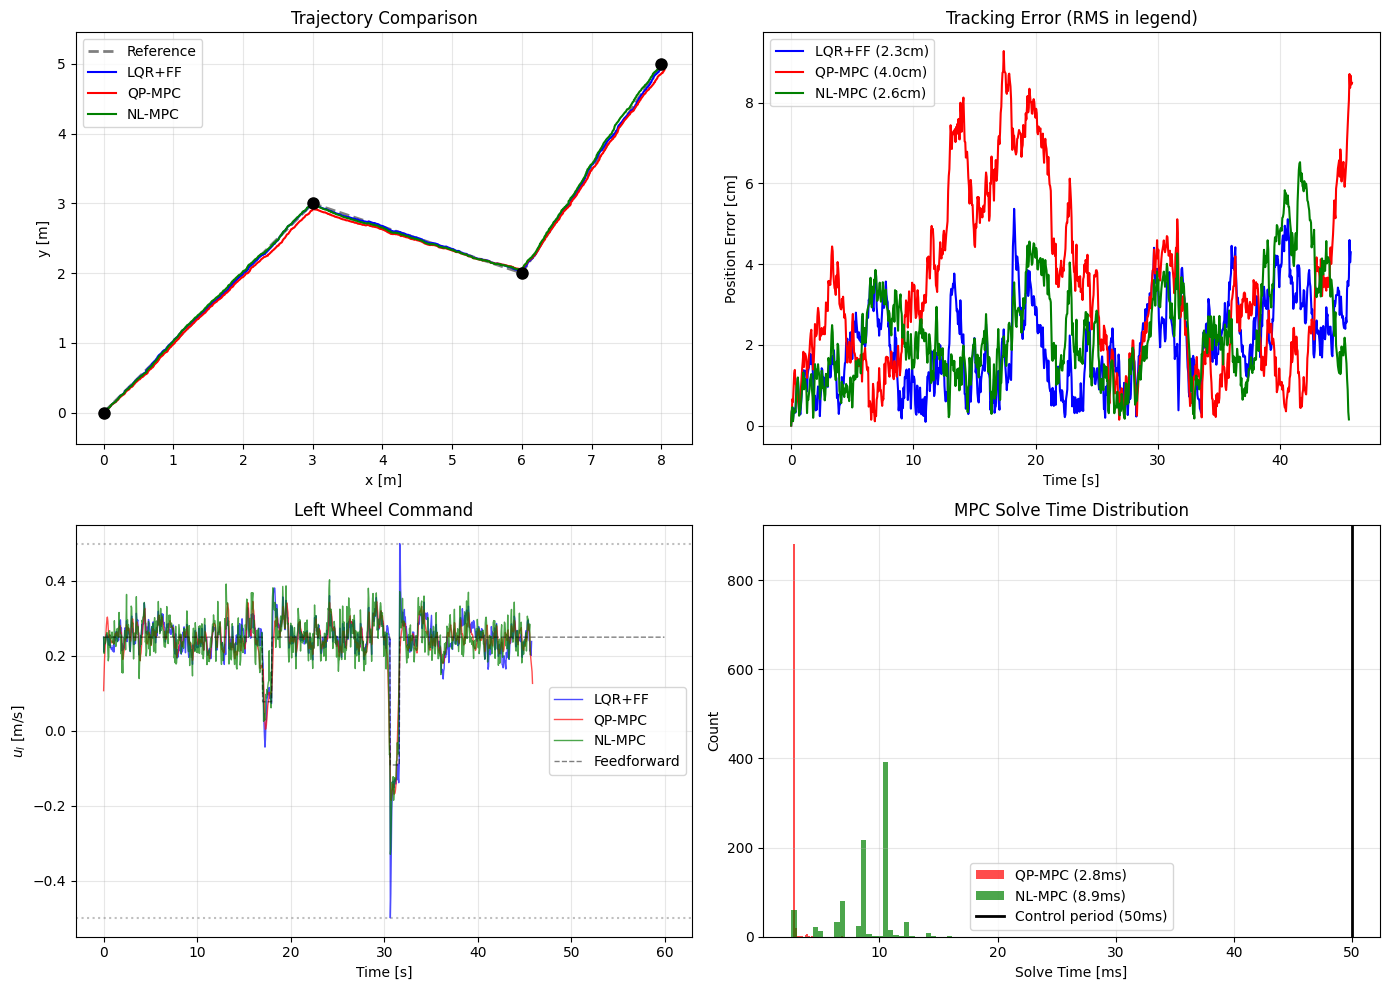

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trajectory comparison
ax = axes[0, 0]
ax.plot(x_ref[0, :], x_ref[1, :], 'k--', linewidth=2, label='Reference', alpha=0.5)
ax.plot(x_lqr[0, :], x_lqr[1, :], 'b-', linewidth=1.5, label='LQR+FF')
ax.plot(x_qpmpc[0, :], x_qpmpc[1, :], 'r-', linewidth=1.5, label='QP-MPC')
ax.plot(x_nlmpc[0, :], x_nlmpc[1, :], 'g-', linewidth=1.5, label='NL-MPC')
ax.plot(waypoints[:, 0], waypoints[:, 1], 'ko', markersize=8)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Trajectory Comparison')

# Tracking error (use individual time arrays)
ax = axes[0, 1]
ax.plot(t_lqr, err_lqr*100, 'b-', linewidth=1.5, label=f'LQR+FF ({rms_lqr*100:.1f}cm)')
ax.plot(t_qpmpc, err_qpmpc*100, 'r-', linewidth=1.5, label=f'QP-MPC ({rms_qpmpc*100:.1f}cm)')
ax.plot(t_nlmpc, err_nlmpc*100, 'g-', linewidth=1.5, label=f'NL-MPC ({rms_nlmpc*100:.1f}cm)')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Position Error [cm]')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Tracking Error (RMS in legend)')

# Control inputs (left wheel)
ax = axes[1, 0]
ax.plot(t_lqr[:-1], u_lqr[0, :-1], 'b-', linewidth=1, label='LQR+FF', alpha=0.7)
ax.plot(t_qpmpc[:-1], u_qpmpc[0, :-1], 'r-', linewidth=1, label='QP-MPC', alpha=0.7)
ax.plot(t_nlmpc[:-1], u_nlmpc[0, :-1], 'g-', linewidth=1, label='NL-MPC', alpha=0.7)
ax.plot(t, u_ref[0, :], 'k--', linewidth=1, label='Feedforward', alpha=0.5)
ax.axhline(u_max, color='gray', linestyle=':', alpha=0.5)
ax.axhline(-u_max, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('$u_l$ [m/s]')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('Left Wheel Command')

# Solve time histogram
ax = axes[1, 1]
ax.hist(np.array(solve_times)*1000, bins=30, alpha=0.7, color='red', label=f'QP-MPC ({np.mean(solve_times)*1000:.1f}ms)')
ax.hist(np.array(solve_times_nl)*1000, bins=30, alpha=0.7, color='green', label=f'NL-MPC ({np.mean(solve_times_nl)*1000:.1f}ms)')
ax.axvline(dt*1000, color='k', linestyle='-', linewidth=2, label=f'Control period ({dt*1000:.0f}ms)')
ax.set_xlabel('Solve Time [ms]')
ax.set_ylabel('Count')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title('MPC Solve Time Distribution')

plt.tight_layout()
plt.show()

In [13]:
print("\n" + "="*70)
print("CONTROLLER COMPARISON")
print("="*70)
print(f"{'Controller':<15} {'RMS Error':<12} {'Solve Time':<15} {'Embedded?':<12}")
print("-"*70)
print(f"{'LQR+FF':<15} {rms_lqr*100:>6.2f} cm    {'< 0.1 ms':<15} {'Yes':<12}")
print(f"{'QP-MPC':<15} {rms_qpmpc*100:>6.2f} cm    {f'{np.mean(solve_times)*1000:.1f} ms':<15} {'Yes (OSQP)':<12}")
print(f"{'NL-MPC':<15} {rms_nlmpc*100:>6.2f} cm    {f'{np.mean(solve_times_nl)*1000:.1f} ms':<15} {'Difficult':<12}")
print("="*70)


CONTROLLER COMPARISON
Controller      RMS Error    Solve Time      Embedded?   
----------------------------------------------------------------------
LQR+FF            2.27 cm    < 0.1 ms        Yes         
QP-MPC            4.05 cm    2.8 ms          Yes (OSQP)  
NL-MPC            2.63 cm    8.9 ms          Difficult   


## Tuning Guidelines

### LQR+FF

- **Q diagonal**: Higher values increase responsiveness to that state error
- **R diagonal**: Higher values reduce control effort (smoother but slower)
- Linearization point affects performance — choose representative operating conditions

### QP-MPC

- **N_horizon**: Longer horizons improve anticipation but increase computation
- **R_rate**: Critical for motor dynamics — higher = smoother control = better tracking with slow actuators
- **exp_weight**: >1.0 emphasizes end-of-horizon accuracy

### NL-MPC

- **N_control**: Reducing this cuts optimization variables (faster) but limits flexibility
- Use when QP-MPC linearization error is unacceptable (large heading changes)

### General

- Always include feedforward — pure feedback will always lag
- Ensure reference trajectory is physically realizable
- Test with realistic noise to validate robustness